# Inferring historical populations sizes using PSMC

The Pairwise Sequentially Markovian Coalescent (PSMC) model uses information in the complete diploid sequence of a single individual to infer the history of population size changes. The method was published in 2011 ([Li and Durbin 2011](https://www.nature.com/articles/nature10231)) in the paper that you discussed in class. It has become a very popular tool in the world of genomics. In this exercise, we first walk through the steps to generate the necessary input data for PSMC. Then we run PSMC on chromosome 2 of an individual from the Simons Diversity Panel and plot the results.

For additional detail on how to run PSMC see the [GitHub page](https://github.com/lh3/psmc) for PSMC source code.

The bam files and reference genome necessary to run the following scripts can be found at: `/home/Data'.

The method you used for base calling in an earlier exercise is state of the art. Unfortunately, to produce the input data for PSMC we cannot just use the base calls or VCF files that we already produced. The first reason is that PSMC required more data than the 10Mb of chromosome 2 that you called bases on. The second reason is that the way you did your base calls do not let us easily produce input data for PSMC, which is a consensus sequence that represents the diploid genome. 

The example individual used below is a Hungarian individual with id ERR1025630. You can replace that to run the same analysis on another individual (The files you produced in the last exercise).

## Install the new conda env and activate it

Move to your folder in the populationgenomics project (somewhere like populationgenomics/students/username/).
Copy the code below and paste it to your commandline

In [ ]:
%%bash
conda env create -f ~/populationgenomics/env/exercise_envs/psmc_wk3.yml
conda activate psmc_wk3

## Calling consensus sequence (read don't run)

Starting from mapped reads, the first step is to produce a consensus sequence in FASTQ format, which stores both the sequence and its corresponding quality scores, that will be used for QC filtering. The consensus sequence has A, T, C or G at homozygous sites, and other letters [IUPAC codes](https://www.bioinformatics.org/sms/iupac.html) to represent heterozygotes. To make the consensus calls, we use the samtools/bcftools suite. We first use `samtools mpileup` to take the mapped reads and produce a VCF file. We then generate a consensus sequence with `bcftools`, which we convert to FASTQ (with some additional filtering) by `vcfutils.pl`. We take advantage of Unix pipes and the ability of `samtools` to work with streaming input and output to run the whole pipeline (`samtools` -> `bcftools` -> `vcfutils.pl`) as one command. We run our consensus calling pipeline, consisting of a linked set of `samtools`, `bcftools`, and `vcfutils.pl` commands:

1. `samtools`:
    - `-Q` and `-q` in mpileup determine the cutoffs for baseQ and mapQ, respectively
    - `-v` tells mpileup to produce vcf output, and `-u` says that should be uncompressed
    - `-f` is the reference fasta used 
    - `-r` is the region to call the mpileup for (in this case, a particular chromosome)
    - `S_Ami-1.chr2.bam` is the bam file to use
2. `bcftools`:
    - call `-c` calls a consensus sequence from the mpileup using the original calling method
3. `vcfutils.pl`:
    - `-d 5` and `-D 100` determine the minimum and maximum coverage to allow for `vcf2fq`, anything outside that range is filtered
    - `-Q 30` sets the root mean squared mapping quality minimum to 30

This takes a long to run (about 5-6 hours) so if you get tired of waiting you can get it here:


~/populationgenomics/data/consensus_fastq/S_Atayal-1.chr2.fq (all the other individuals should be there as well)

## Creating a PSMC input file

PSMC takes the consensus FASTQ file, and infers the history of population sizes, but first we need to convert this FASTQ file to the input format for PSMC (make sure that your paths are correct, if you remember how to you can create a soft link to the files):

In [ ]:
%%bash
fq2psmcfa -q20 S_Atayal-1.chr2.fq > S_Atayal-1.chr2.psmcfa

This transforms the consensus sequence into a fasta-like format where the i-th character in the output sequence indicates whether there is at least one heterozygote in the bin [100i, 100i+100). Have a look at the file using `less`.

## Running PSMC
Now we are finally ready to run PSMC. You do that like this:

%%bash
psmc -N50 -t15 -r5 -p "4+25*2+4+6" -o S_Atayal-1.chr2.psmc S_Atayal-1.chr2.psmcfa

The command line in the example above has been shown to be suitable for modern humans, inappropiate settings might lead to under/over-fitting. The `-p` and `-t` options are used to specify the length and number of time intervals. The `-r` option is used to specify the initial theta/rho ratio. The `-N` option sets the maximum number of EM iterations in the fitting of model parameters.

This PSMC analysis takes about 25 minutes to complete. So go for a coffee and talk about how wild it is that each of us carry around information about the entire human past!!! Honestly WTF

## Plot your results

This might be the most complicated step, but I have make some functions that should make it easier

In [24]:
# load in the relevant packages
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np

You don't really have to understand the next block, it just reads the funky file format

In [42]:
# Insert the path to the psmc file here
psmc_path = 'S_Atayal-1.chr2.psmc'
psmc_rlt = open(psmc_path, "r")
result = psmc_rlt.read()
mutation=1.2e-8
generation_time=29
size=1e4
# Getting the time windows and the lambda values
last_block = result.split('//\n')[-2]
last_block = last_block.split('\n')
time_windows = []
estimated_lambdas = []
for line in last_block:
    if line[:2] =="RS":
        time_windows.append(float(line.split('\t')[2]))
        estimated_lambdas.append(float(line.split('\t')[3]))
result = result.split('PA\t')
result = result[-1].split('\n')[0]
result = result.split(' ')
theta = float(result[1])
N0 = theta/(4*mutation)/size
times = [generation_time * 2 * N0 * i for i in time_windows]
sizes = [N0 * i for i in estimated_lambdas]
# Remove the false positive result
raw_dict = {}
false_result = sizes[-1]
for i in range(len(sizes)):
    raw_dict[times[i]] = sizes[i]
times = []
sizes = []
for k, v in raw_dict.items():
    if str(v) != str(false_result):
        times.append(k)
        sizes.append(v)
    else:
        break
df = pd.DataFrame({'times':times,'population_size':sizes})

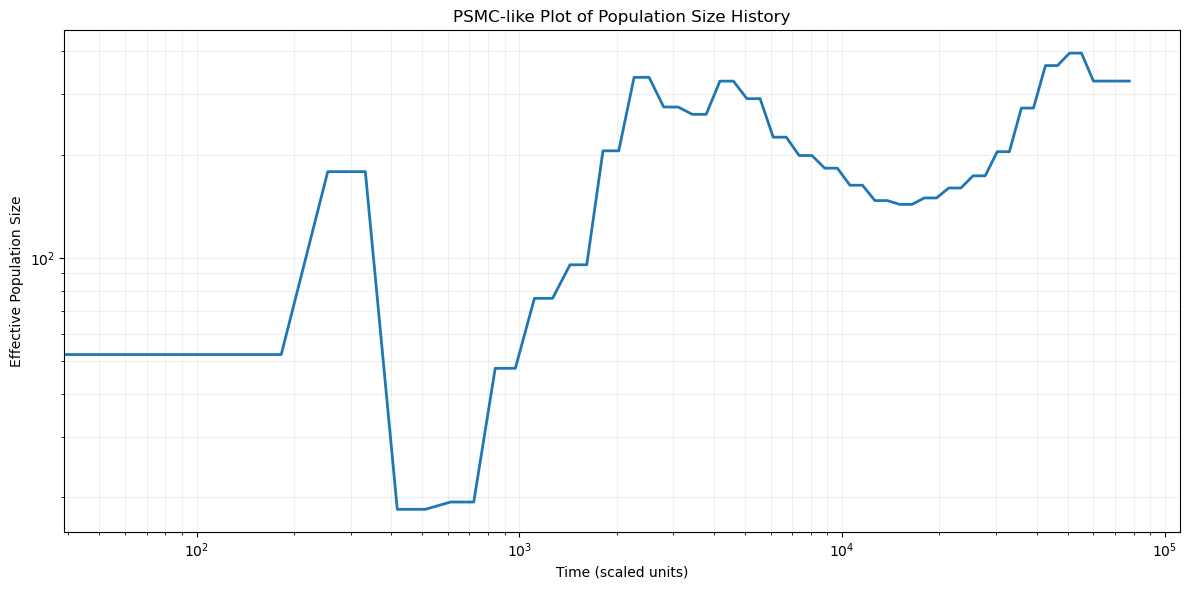

In [43]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df['times'], df['population_size'], '-', linewidth=2)

# Set log scale for both axes (common in PSMC plots)
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Time (scaled units)')
plt.ylabel('Effective Population Size')
plt.title('PSMC-like Plot of Population Size History')

# Grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Now try to compare between different populations. What does this tell you?